In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
np.sqrt(-1+0j)

## The following doesn't work since the input is of type float 
## which corresponds to a real value (not complex)
# np.sqrt(-1)

1j

In [3]:
def get_k(energy, constant_potential):
    """Return k == \sqrt{2m(E-V0)}/hbar for constant potential V0"""
    m, hbar = 1.0, 1.0  # using atomic unit
    E, V0 = energy, constant_potential  # aliasing for convenience
    k = np.sqrt(2*m*(E-V0)+0j) / hbar
    return k

def f(x, energy, constant_potential):
    """Return one solution of time-independent schrödinger equation for a given constant potential
    
    Corresponding k == \sqrt{2m(E-V0)}/hbar is the second return value.
    
    The solution is returned in a form of exponential.
    Thus, the other linearly independent solution can be obtained by inverting its solution
    Namely, letting `f1` the solution obtained by this method, 
    the other linearly independet solution is `1 / f1`
    """
    k = get_k(energy, constant_potential)
    f_val = np.exp(1.0j * k * x)
    return f_val, k

In [4]:
from numbers import Integral

def sol(x, energy, constant_potential, sol_index, diff_number):
    for int_args in [sol_index, diff_number]: assert isinstance(int_args, Integral)
    assert sol_index in [1, 2]
    # [180423 NOTE] `diff_number` can also be negative, representing integral
    # assert diff_number >= 0
    
    f_val, k = f(x, energy, constant_potential)
    diff_factor = None
    if sol_index == 1: diff_factor = 1.0j * k
    elif sol_index == 2:
        f_val **= -1
        diff_factor = - 1.0j * k
    else: raise Exception("Unexpected solution index: {0}".format(sol_index))
    f_val *= diff_factor ** diff_number
    return f_val

In [5]:
from numbers import Number

def W(x, energy, constant_potential):
    """Calculate Wronskian matrix for two solutions under given constant potential"""
    assert isinstance(x, Number)
    wronskian = np.empty((2,2), dtype=complex)
    for idx0, diff_number in enumerate([0,1]):
        for idx1, sol_index in enumerate([1,2]):
            wronskian[idx0, idx1] = sol(x, energy, constant_potential, sol_index, diff_number)
    return wronskian

### Test plotting

In [6]:
x = np.linspace(-2,2,100)

In [7]:
f_val, k = f(x, 0.6, 1.0)
f_val_sol = sol(x, 0.6, 1.0, 1, 0)

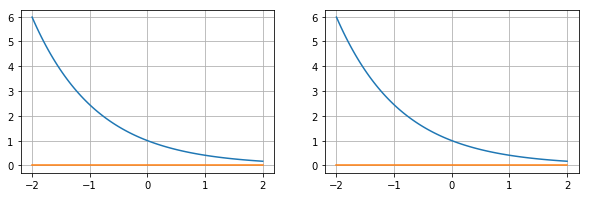

In [8]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
axes[0].plot(x,f_val.real)
axes[0].plot(x,f_val.imag)
axes[1].plot(x,f_val_sol.real)
axes[1].plot(x,f_val_sol.imag)

# Step potential

### Set free variables (coefficients)

In [9]:
A2, B2 = 1, 0

### Set system variables

In [10]:
E, V0 = 1.5, 1.0  # total energy / constant potential energy

In [11]:
x1 = 3  # boundary coordinate

### Solve for coefficients

In [12]:
W1 = W(x1, E, 0.0)
W2 = W(x1, E, V0)

In [13]:
b = W2 @ [A2, B2]

In [14]:
A1, B1 = np.linalg.solve(W1, b)

In [15]:
x_arr = np.linspace(-15,15,1000)
x_I0 = x_arr[x_arr < x1]
x_I1 = x_arr[x_arr >= x1]

In [16]:
psi_1 = A1 * sol(x_I0, E, 0.0, 1, 0) + B1 * sol(x_I0, E, 0.0, 2, 0)
psi_2 = A2 * sol(x_I1, E, V0, 1, 0) + B2 * sol(x_I1, E, V0, 2, 0)

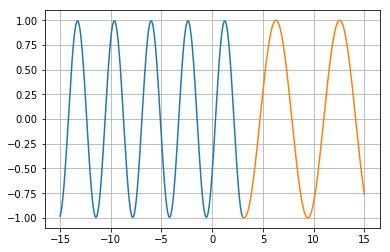

In [17]:
fig, ax = plt.subplots()
ax.plot(x_I0, psi_1.real)
ax.plot(x_I1, psi_2.real)

In [18]:
#fig.savefig('step-pot-using-wronskian-A2-1-B2-0.png')

# [ Finite Barrier ]

## Generating an image for finite barrier potential

### Configure system parameters

In [19]:
N_intervals = 3
x_min = -3
x_max = '+infinity'
num_step_boundray_coords = N_intervals - 1
step_boundary_coords = np.array([1.0, 1.5])

# num_boundary_coords = N_intervals - 1
# if x_min != '-infinity': num_boundary_coords += 1
# if x_max != '+infinity': num_boundary_coords += 1
# boundary_coords = np.array([1,1.5])

V0_array = np.array([0, 2, 0], dtype=float)

assert V0_array.size == N_intervals
# assert boundary_coords.size == num_boundary_coords
assert step_boundary_coords.size == num_step_boundray_coords


x_lim = [-25,25]
from numbers import Number
if isinstance(x_min, Number): x_lim[0] = x_min
if isinstance(x_max, Number): x_lim[1] = x_max
assert x_lim[0] < x_lim[1]
for x_i in step_boundary_coords: assert (x_i > x_lim[0]) and (x_i < x_lim[1])

### Configure plotting parameters

##### data

In [20]:
def get_coords_in_fig_of_potential(step_boundray_coords, x_lim):
    N_intervals = step_boundray_coords.size + 1
    coords_in_fig = np.empty((N_intervals+1,), dtype=float)
    coords_in_fig[0], coords_in_fig[-1] = x_lim
    if (step_boundray_coords.size == N_intervals - 1) and (coords_in_fig.size == N_intervals + 1):
        coords_in_fig[1:-1] = step_boundary_coords
    else: raise Exception("Unexpected number of step boundary: {0}".format(step_boundary_coords.size))
    return coords_in_fig

coords_in_fig = get_coords_in_fig_of_potential(step_boundary_coords, x_lim)
assert coords_in_fig.size - 1 == V0_array.size

##### appearence

In [21]:
potential_kwargs = {'color':(1,0,0,0.5)}

### Draw

In [22]:
def draw_potential(ax, step_boundary_coords, **potential_kwargs):
    from matplotlib.axes import Axes
    assert isinstance(ax, Axes)
    coords_in_fig = get_coords_in_fig_of_potential(step_boundary_coords, x_lim)
    for idx in range(coords_in_fig.size - 1):
        x_data = [coords_in_fig[idx], coords_in_fig[idx+1]]
        y_data = [V0_array[idx], V0_array[idx]]
        ax.plot(x_data, y_data, **potential_kwargs)

    for idx in range(coords_in_fig.size - 2):
        x_data = [coords_in_fig[idx+1]] * 2
        y_data = [V0_array[idx], V0_array[idx+1]]
        ax.plot(x_data, y_data, linestyle=':', **potential_kwargs)

Text(0,0.5,'energy / a.u.')

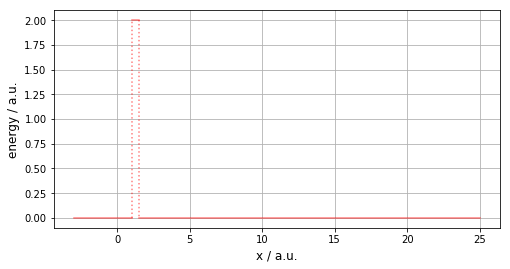

In [23]:
fig, ax = plt.subplots(figsize=(8,4))

draw_potential(ax, step_boundary_coords, **potential_kwargs)

ax.set_xlabel('x / a.u.')
ax.set_ylabel('energy / a.u.')

# Solve system of linear equations for unknown coefficients

### Set energy

In [24]:
E = 0.2

### Set free coefficients

In [25]:
step_boundary_coords

array([1. , 1.5])

In [26]:
coef_array = np.empty((N_intervals,2), dtype=complex)

from numbers import Number
if isinstance(x_min, Number):
    f1, f2 = W(x_min, E, V0_array[0])[0,:]
    a = 1
    b = - a * f1 / f2
    coef_array[0,:] = [a, b]
else:
    coef_array[0,:] = [1, 0]

### Solve equations using matrix

In [27]:
step_boundary_coords

array([1. , 1.5])

In [28]:
for idx in range(N_intervals - 1):
    A = W(step_boundary_coords[idx], E, V0_array[idx+1])
    b = W(step_boundary_coords[idx], E, V0_array[idx]) @ coef_array[idx,:]
    coef_array[idx+1,:] = np.linalg.solve(A,b)

In [29]:
coef_array

array([[ 1.        +0.j        ,  0.79417926-0.60768355j],
       [ 5.35078223-1.81229513j,  0.04281573-0.01450157j],
       [-0.48507755-0.72600389j,  0.05594209+0.87135088j]])

### Reconstruct solution

In [30]:
coords_in_fig

array([-3. ,  1. ,  1.5, 25. ])

In [31]:
x_arr = np.linspace(*x_lim,1000)

In [32]:
def linear_sum_sol_in_same_interval(x, energy, constant_potential, coefs, diff_number=0):
    assert len(coefs) == 2
    summed_sol = 0.0
    for idx, sol_index in enumerate(range(1,len(coefs)+1)):
        summed_sol += coefs[idx] * sol(x, energy, constant_potential, sol_index, diff_number)
    return summed_sol

# [TODO] Consider separating edge coordinate and step boundary coordinates
- The step-boundary coordinate is the coordinate value of a boundary of two intervals with different potential value
- The edge coordinate is the coordinate of infinite potential wall, if any. Thus, if the boudnary condition doesn't include infinite potential wall but other type such as constant potential to infinity, the edge coordinate doesn't exist.
- Make separate variable for left and right edge coordinate respectively seems to be nice for dealing with multiple boundary and edge conditions

# [TODO] Fix `get_interval_mask()` and `global_sol()` accordingly.

In [33]:
def get_interval_mask(x, step_boundary_coords, idx):
    num_of_step_boundary = step_boundary_coords.size
    if idx == 0: x_interval_mask = x < step_boundary_coords[idx]
    elif idx == N_intervals - 1: x_interval_mask = x >= step_boundary_coords[idx-1]
    else: x_interval_mask = (x >= step_boundary_coords[idx-1]) & (x < step_boundary_coords[idx])
    return x_interval_mask

from numbers import Integral, Number
def global_sol(x, energy, V0_array, step_boundary_coords, coef_array, diff_number=0):
    assert isinstance(diff_number, Integral)
    assert isinstance(energy, Number)
    assert isinstance(x, np.ndarray)
    assert len(V0_array) == len(coef_array)
    N_intervals = len(V0_array)
    global_sol_array = np.empty_like(x, dtype=complex)
    for idx in range(N_intervals):
        x_interval_mask = get_interval_mask(x, step_boundary_coords, idx)
        x_interval = x[x_interval_mask]
        global_sol_array[x_interval_mask] = linear_sum_sol_in_same_interval(
            x_interval, energy, V0_array[idx], coef_array[idx,:], diff_number)
    return global_sol_array

In [34]:
sol_array = global_sol(x_arr, E, V0_array, step_boundary_coords, coef_array)

# [TODO] Outside of infinite potential wall should be truncated and shouldn't be shown in the plot

In [35]:
from matplotlib import rcParams
rcParams['font.size'] = 15

Text(0,0.5,'energy')

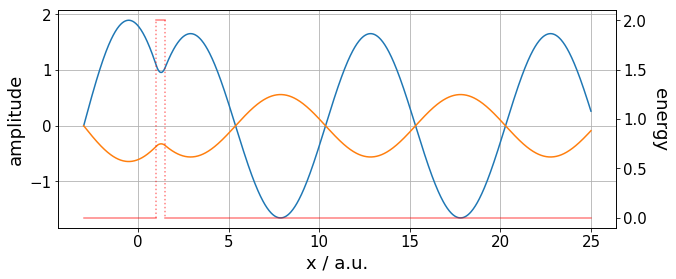

In [36]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

ax.plot(x_arr, sol_array.real)
ax.plot(x_arr, sol_array.imag)
ax.set_xlabel('x / a.u.')
ax.set_ylabel('amplitude')

pot_ax = ax.twinx()
pot_ax.grid(False)
draw_potential(pot_ax, step_boundary_coords, **potential_kwargs)
pot_ax.set_ylabel('energy', rotation=270, va='bottom')

# axes[1].plot(x_arr, sol_array.real)
# axes[1].plot(x_arr, sol_array.imag)
# axes[1].set_xlim(-2,3)

In [37]:
fig.tight_layout()
#fig.savefig('finite-potential-wall-with-one-sided-infinite-edge-example.png')